# Instructions

1. Review `Data Organization` and `Excel Scan Order Sheets` sections below.
2. Move script file to BASE_SOURCE_FOLDER.
3. Create new [projectName]_BIDS subdirectory in BASE_SOURCE_FOLDER if it does not already exist (e.g. `RAID_BIDS`).
4. Then run the script cell-by-cell on your Linux machine.
5. The last 2 cells include options for converting an entire directory vs a single participant. Run whichever you desire accordingly.

Questions can be directed to Ohad (ohad.dan@yale.edu) or Chelsea (chelsea.xu@yale.edu).

# Data Organization (of raw dicom files)

To successfully run, this script assumes that the source files are all organized under:

* BASE_SOURCE_FOLDER (e.g. `'/RAID/raw_dicom/'`)
* That folder, contain one folder per participant, named projectName_participantId (e.g. `RAID_10` for a project named RAID and participant 10)
* Each participant folder contains folders of scans, named projectName_participantId_scan[NUMBER]_someSuffix (e.g. `RAID_10_scan2_pc1079_levy` for the second scan), and excel sheets with the scan order for each scan, named projectName_participantID_scan[NUMBER]_order

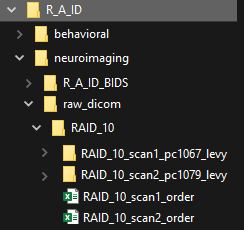

# Excel Scan Order Sheets

Excel sheets with scan order should contain 2 columns. The first colum should contain block number. Second column should contain task name (no spaces or underscores). Blocks of the same task should have a number after it (e.g. `gain1`, `gain2`). Aborted blocks should just be denoted by "aborted". See example below.

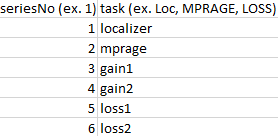

In [1]:
conda install -c conda-forge/label/cf201901 dcm2niix

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3\envs\py37_dev

  added / updated specs:
    - dcm2niix


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1n             |       h2bbff1b_0         5.8 MB
    ------------------------------------------------------------
                                           Total:         5.8 MB

The following packages will be UPDATED:

  openssl                                 1.1.1m-h2bbff1b_0 --> 1.1.1n-h2bbff1b_0




Note: you may need to restart the kernel to use updated packages.

openssl-1.1.1n       | 5.8 MB    |            |   0% 
openssl-1.1.1n       | 5.8 MB    | ###6       |  36% 
openssl-1.1.1n       | 5.8 MB    | ########## | 100% 
openssl-1.1.1n       | 5.8 MB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done

In [2]:
!pip install openpyxl

In [2]:
import os
from nipype.interfaces.dcm2nii import Dcm2niix
import shutil
import pandas as pd

In [3]:
from pathlib import Path

# Script constants


In [26]:
BASE_SOURCE_FOLDER = '.'
PROJECT_NAME = os.getcwd().split('/')[-3]  ## Should extract the project name, e.g. 'RAID'
BASE_OUTPUT_FOLDER = os.path.dirname(os.getcwd()) + '/' + PROJECT_NAME + '_BIDS'
VERBOSE_MESSAGES = True

['RAID', 'sub-10']


## Helper functions

In [6]:
def get_all_session_folder_names_for_participant(subName):
    '''
    Return all the session folder names for the input participants.
    For example, if a participant has sessions in the source folder named
    RAID_10_scan1_pc1067_levy and RAID_10_scan2_pc1079_levy, this function 
    will return the list with ['RAID_10_scan1_pc1067_levy', 'RAID_10_scan2_pc1079_levy']
    '''
    participant_path = os.path.join(BASE_SOURCE_FOLDER, PROJECT_NAME + '_' + str(subName))
    return next(os.walk(participant_path))[1]

def debug_message(message):
    if VERBOSE_MESSAGES:
        print('###' + message)
        
def create_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)
    
def participant_output_path(subName):
    return BASE_OUTPUT_FOLDER + '/' + 'sub-' + str(subName) + '/'

# Run the BIDS conversion
Documentation for the converter may be found [here](https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage#General_Usage) (e.g. what are the cryptic `%d, %a, %c`)

In [7]:
#%% Convert functions Converts DICOM to NIFTI.GZ
def convert_single_session(converter, subName, session_folder, session_number):
    '''
    Perform bids conversion for a single session of a single participant.
    converter:  Is a Dcm2niix object
    participant_number: is an integer which identifies the participant
    session_number: an integer representing a valid session of that participant
    '''
    converter = Dcm2niix()
    converter.inputs.source_dir = BASE_SOURCE_FOLDER + '/' + PROJECT_NAME + '_' + str(subName) + '/' + session_folder
    output_folder = participant_output_path(subName) + 'ses-' + str(session_number)
    if os.path.isdir(output_folder): #check if output folder exists
        debug_message('Folder ' + output_folder + ' already exists.')
        if os.listdir(output_folder): #check if output folder is empty
            debug_message('Folder ' + output_folder + ' already exists and is non-empty. Skipping conversion.')
            return #stop execution if folder has items    
    else: #otherwise make new output folder
        os.mkdir(output_folder)
    converter.inputs.output_dir = output_folder
    
    debug_message('Converting from: ' + converter.inputs.source_dir)
    debug_message('Converting to: ' + converter.inputs.output_dir)
    
    converter.inputs.out_filename = str(subName) + '%d' + '%a' + '%c' + '_' + '%2s' # %2s adds the scan block number
    ## 10_cmrr_mbep2d_bold(MB4iPAT2)a.nii.gz vs 10cmrr_mbep2d_bold(MB4iPAT2)HEA;HEPUnaliased_MB4_PE403.nii.gz
    
    converter.run()
    return output_folder
    
def convert_single_participant(subName, converter):
    participant_sessions = get_all_session_folder_names_for_participant(subName)
    for session_number,session_folder_name in enumerate(participant_sessions): # session numbers are enumerated sequentially from 0, 
                                                                            # we add 1 to output sessions starting from 1
        create_dir(participant_output_path(subName))
        output_folder = convert_single_session(converter, subName, session_folder_name, session_number+1)
    return participant_sessions, output_folder

# Organize conversion output to BIDS folder structure
write function organize_directory to organize to BIDS format
* __anat/__ - Anatomical holds the blocks: _mprage_, _flash_, _T2w_
* __func/__ - Functional holds the task blocks
* __dwi/__ - Diffusion weighted imaging
* __misc/__ - Miscellaneous holds the blocks: _localizer_

In [20]:
def file_suffix(file_name):
    if file_name.endswith('json'):
        return '.json'
    if file_name.endswith('.nii.gz'):
        return '.nii.gz'
    if file_name.endswith('bvec'):
        return '.bvec'
    if file_name.endswith('bval'):
        return '.bval'

def get_all_files_in_dir(output_folder):
    return next(os.walk(output_folder))[2]

def get_file_subdir(file_name):
    if 'T1w' in file_name:
        return 'anat'
    elif 'localizer' in file_name:
        return 'misc'
    elif 'aborted' in file_name:
        return 'misc'
    elif 'bold' in file_name:
        return 'func'
    elif 'T2w' in file_name:
        return 'anat'
    elif 'dwi' in file_name:
        return 'dwi'
    else:
        return 'misc'
    
def get_file_new_name(subName, session, file_name):
    if 'localizer' in file_name: 
        localizer_run_number = int(file_name.split('.')[0][-1])
        return 'sub-' + str(subName) + '_ses-' + str(session) + '_' + 'localizer_run-' + str(localizer_run_number) + file_suffix(file_name)
    elif 'MPRAGE' in file_name:
        return 'sub-' + str(subName) + '_ses-' + str(session) + '_' + 'acq-mprage_T1w' + file_suffix(file_name)
    elif 'diff' in file_name:
        return 'sub-' + str(subName) + '_ses-' + str(session) + '_' + 'dwi' + file_suffix(file_name)
    elif 't1_flash' in file_name:
        return 'sub-' + str(subName) + '_ses-' + str(session) + '_' + 'acq-FLASH_T1w' + file_suffix(file_name)
    elif 't2' in file_name:
        return 'sub-' + str(subName) + '_ses-' + str(session) + '_' + 'T2w' + file_suffix(file_name)
    else:
        idx = int(file_name.split('.')[0].split('_')[-2]) - 1
        blocks = read_scan_blocks (subName, session) #from excel sheet 
        return 'sub-' + str(subName) + '_ses-' + str(session) + '_task-' + blocks[idx] + '_bold' + file_suffix(file_name)

def move_and_rename(file_name, file_target_subdirectory, file_new_name):
    shutil.move(file_name, file_target_subdirectory + '/' + file_new_name)

def organizeFiles(output_folder, subName, session):
    all_files = get_all_files_in_dir(output_folder)
    for file_name in all_files:
        file_new_name = get_file_new_name(subName, session, file_name) #get new file name
        print("Renaming " + file_name + " to " + file_new_name)
        file_target_subdirectory = get_file_subdir(file_new_name) #get new subdirectory for file
        new_output_dir = str(output_folder) + '/' + file_target_subdirectory
        if not os.path.exists(new_output_dir):
            os.makedirs(new_output_dir)
        # file_new_name = get_file_new_name(subName, session, file_name) #get new file name
        move_and_rename(output_folder + '/' + file_name, output_folder + '/' + file_target_subdirectory, file_new_name) #move to subdirectory as new file name

In [9]:
def read_scan_blocks (sub_num, scan_num):
    """
    """
    sub_name = PROJECT_NAME + '_' + str(sub_num)
    scan_file = sub_name + '_scan' + str(scan_num) + '_order.xlsx'
    file_name = BASE_SOURCE_FOLDER + '/' + sub_name + '/' + scan_file
    dfs = pd.read_excel(file_name, sheet_name=None)
    return list(dfs['Sheet1'].iloc[:,1])

['localizer', 't1flash', 'aborted', 'task_loss', 'task_loss', 'task_gain', 'task_gain', 'resting']


In [ ]:
# for the entire directory

subNames = [int(x.split('_')[1]) for x in next(os.walk(BASE_SOURCE_FOLDER))[1] if PROJECT_NAME in x and 'BIDS' not in x]
subNames.sort()
print(subNames)
for subName in subNames:
    print(subName)
    participant_sessions = convert_single_participant(subName, Dcm2niix())
    print(participant_sessions)
    for session_number in range(len(participant_sessions)):
        session = session_number + 1
        output_folder = BASE_OUTPUT_FOLDER + '/' + 'sub-' + str(subName) + '/' + 'ses-' + str(session)
        print(session)
        organizeFiles(output_folder, subName, session)

In [23]:
# for a single subject

subName = 10 #replace participant number e.g. "subName = 10"
participant_sessions = convert_single_participant(subName, Dcm2niix())
for session_number in range(len(participant_sessions)):
    session = session_number + 1
    output_folder = BASE_OUTPUT_FOLDER + '/' + 'sub-' + str(subName) + '/' + 'ses-' + str(session)
    organizeFiles(output_folder, subName, session)